<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA6_StanIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install cmdstanpy module
# !pip install cmdstanpy

# Install arviz module (With version 2.33.1 you will need a special version of arviz)
# !pip install git+https://github.com/OriolAbril/arviz.git@ci

!pip list | grep cmdstanpy
!pip list | grep arviz

cmdstanpy                          1.2.5
arviz                              0.20.0


In [ ]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmp122ww9ml
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [ ]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [ ]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Stan is a probabilistic programming language

It implements state of the art HMC algorithms.

Specifically, its default is the No-U-Turn Sampler by [Hoffman and Gelman (2014)](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) with some further improvements.

Given a target probability density function, the sampling is divided in

1. **Adaptation**: the algorithm learns the "optimal" stepsize $\varepsilon$, integration time $L$ and mass matrix $M$ of the momentum conditional distribution. The idea is to optimize these parameters so that the acceptance rate of the algorithm is 80%. This is done by first reaching the typical set, then learning $M$ and finally $L$ and $\varepsilon$.

2. **Burnin**: A number of iterations that will be discarded

3. Proper **sampling**


By default 1000 iterations of adaptation, 0 of burnin and 1000 of sampling (no thinning!)

## Stan can sample from my distributions!

In [ ]:
normal_code = """
    data {
        int<lower=0> dim;
        matrix[dim, dim] cov_chol;
    }

    parameters {
        vector[dim] x;
    }

    model {
        vector[dim] mu = rep_vector(0, dim);
        x ~ multi_normal_cholesky(mu, cov_chol);
    }
"""

# Set Data
d = 2
sigma = 0.99 ** np.abs(np.vstack([np.arange(d)] *d) - np.vstack([np.arange(d)] *d).T)
sigma_chol = np.linalg.cholesky(sigma)

# Write model to file
stan_file = "./stan/multi_normal.stan"
with open(stan_file, "w") as f:
    print(normal_code, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

19:47:21 - cmdstanpy - INFO - compiling stan file /content/stan/multi_normal.stan to exe file /content/stan/multi_normal
INFO:cmdstanpy:compiling stan file /content/stan/multi_normal.stan to exe file /content/stan/multi_normal
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=multi_normal.stan /content/stan/multi_normal
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=multi_normal.stan --o=/content/stan/multi_normal.hpp /content/stan/multi_normal.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/s

In [ ]:
# Prepare data list for stan
normal_data = {
    "dim": 2,
    "cov_chol": sigma_chol
}

# Run the sampler
stan_fit = stan_model.sample(data=normal_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /content/stan/multi_normal info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseieqfx9/f8ywhb78.json
19:47:43 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal', 'id=1', 'random', 'seed=28595', 'data', 'file=/tmp/tmpseieqfx9/f8ywhb78.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normaldkcxoz3k/multi_normal-20250208194743_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal', 'id=2', 'random', 'seed=28595', 'data', 'file=/tmp/tmpseieqfx9/f8ywhb78.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normaldkcxoz3k/multi_normal-20250208194743_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal', 'id=3', 'random', 'seed=28595', 'data', 'file=/tmp/tmpseieqfx9/f8ywhb78.json', 

19:47:46 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/multi_normal', 'id=1', 'random', 'seed=28595', 'data', 'file=/tmp/tmpseieqfx9/f8ywhb78.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normaldkcxoz3k/multi_normal-20250208194743_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpseieqfx9/multi_normaldkcxoz3k/multi_normal-20250208194743_1.csv
 console_msgs (if any):
	/tmp/tmpseieqfx9/multi_normaldkcxoz3k/multi_normal-20250208194743_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
   

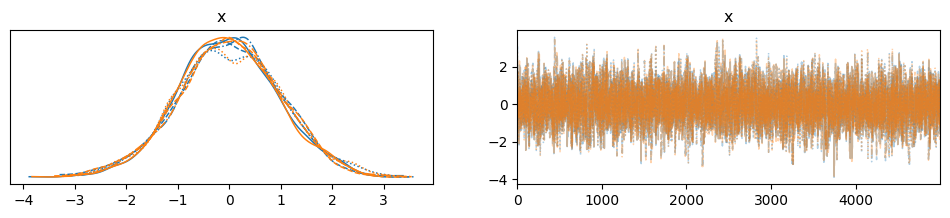

In [ ]:
# Some plot using arviz
az.plot_trace(cmdstanpy_data)
plt.show()

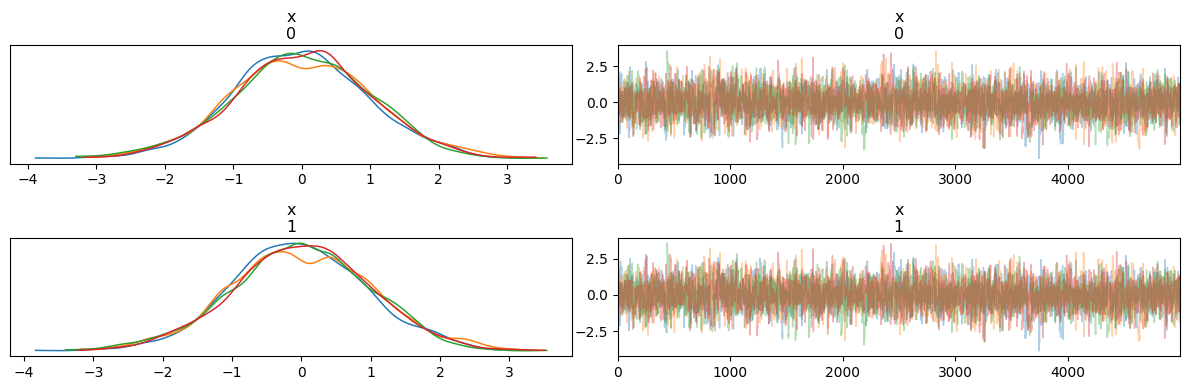

In [ ]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

Let'see how `stan` has explored the level set of the target distribution:

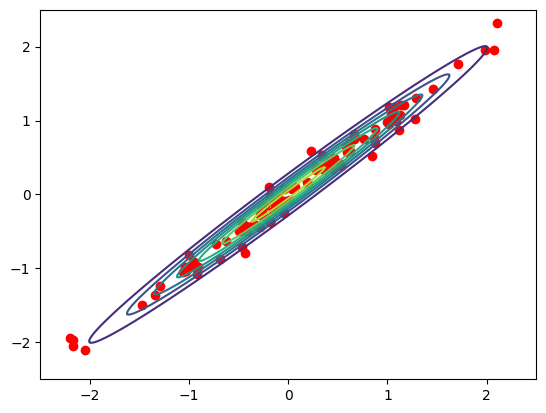

In [ ]:
# Plot the contour of the target distribution (i.e. 2D Gaussian distribution)
x = y = np.linspace(-2.5, 2.5, 200)
X, Y = np.meshgrid(x, y)
pos = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
z = tfd.MultivariateNormalFullCovariance(np.zeros(2), sigma).prob(pos)
plt.contour(X, Y, z.reshape(X.shape))

# Add first N saved iterations
N = 100
plt.scatter(cmdstanpy_data.posterior.x[0, :N, 0], cmdstanpy_data.posterior.x[0, :N, 1], color="red")
plt.show()

### Compute running average of $\sum x_i$ when $d=10$

In [ ]:
d = 10
sigma = 0.8 ** np.abs(np.vstack([np.arange(d)] * d) - np.vstack([np.arange(d)] * d).T)
sigma_chol = np.linalg.cholesky(sigma)

normal_data = {
    "dim": d,
    "cov_chol": sigma_chol
}

stan_fit = stan_model.sample(data=normal_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000, show_progress="notebook")

cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /content/stan/multi_normal info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseieqfx9/0r4h4nyh.json
19:48:52 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal', 'id=1', 'random', 'seed=39885', 'data', 'file=/tmp/tmpseieqfx9/0r4h4nyh.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal', 'id=2', 'random', 'seed=39885', 'data', 'file=/tmp/tmpseieqfx9/0r4h4nyh.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal', 'id=4', '

19:48:55 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/multi_normal', 'id=1', 'random', 'seed=39885', 'data', 'file=/tmp/tmpseieqfx9/0r4h4nyh.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_1.csv
 console_msgs (if any):
	/tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
   

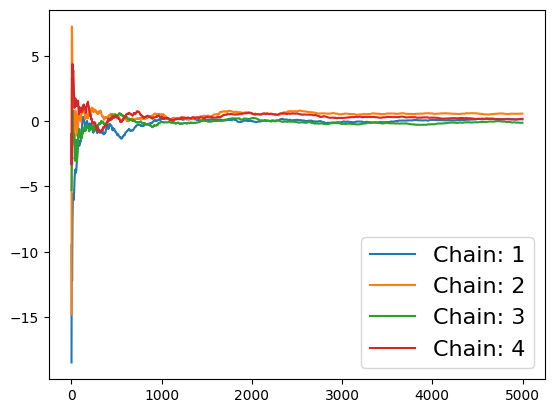

In [ ]:
running_sum = np.cumsum(np.sum(cmdstanpy_data.posterior.x, axis=-1), axis=1)
running_avg = running_sum / np.arange(running_sum.shape[1])

for i in range(4):
    plt.plot(running_avg[i, :], label="Chain: {0}".format(i+1))
plt.legend(fontsize=16)
plt.show()

## Multiple chains are useful for assessing convergence - $\hat{R}$ and ESS

$\hat{R}$ is a diagnostic of convergence: Implementation in Stan follows [Vehtari et al. (2021)][1]. Check it out for further details.

In the equations below, $N$ is the number of draws per chain, $M$ is the number of chains, $S=MN$ is the total number of draws from all
chains, $\theta^{(nm)}$ is $n$-th draw of $m$-th chain, $\bar{\theta}^{(\bullet m)}$ is the average of draws from $m$-th chain, and $\bar{\theta}^{(\bullet\bullet)}$ is average of all draws.  

1. For each scalar quantity of interest $\theta$, first compute $B$ and $W$, the between- and within-chain variances:
\begin{align*}
   B &= \frac{N}{M-1} \sum_{m=1}^{M} \left( \bar{\theta}^{(\bullet m)} - \bar{\theta}^{(\bullet\bullet)} \right)^2 \\
   W &= \frac{1}{M} \sum_{m=1}^{M} s^{2}_{m} \quad\text{where}\quad s^{2}_{m} = \frac{1}{N-1}\sum_{n=1}^{N} \left( \theta^{(nm)} - \bar{\theta}^{(\bullet m)} \right)^2
\end{align*}
2. Estimate $\text{var}(\theta \mid y)$, the marginal posterior variance of the estimand, by a weighted average of $W$ and $B$:
\begin{equation*}
    \hat{\text{var}}^{+}\left( \theta \mid y \right) = \frac{N-1}{N}W + \frac{1}{N}B
\end{equation*}
3. Compute $\hat{R}$ as:
\begin{equation*}
    \hat{R} = \sqrt{\frac{\hat{\text{var}}^{+}\left( \theta \mid y \right)}{W}}
\end{equation*}

In practice, we monitor convergence of the iterative simulations to the target distribution by estimating the factor by which the scale of the current distribution for $\theta$ might be reduced if the simulations were continued in the limit $N \to \infty$. In fact, the above estimator, for an ergodic process, declines to $1$ as $N \to \infty$. Hence, a value as close as possible to $1$ means that the chain converged. **Rule of thumb**: if $\hat{R} > 1.1$, the chain did not converge!

> *Indeed the actual implementation of $\hat{R}$ in Stan does not use actual draws $\theta^{(nm)}$'s, but either their rank normalization or the rank normalization of the folded draws, i.e. the absolute deviation of $\theta^{(nm)}$ from the median. See [Vehtari et al. (2021)][1] for all the details.*

The **effective sample size** (ESS) is an estimate of the sample size required to achieve the same level of precision if that sample was a simple random sample. Still, refer to Section 3.2 in [Vehtari et al. (2021)][1] for the estimation of ESS with multiple chains. We want it to be as close as possible to the actual draws of our chain. Notice that with Stan, if we are close to normality, we can reach values that are higher than the sample size in case of parameters whose posterior is close to a Gaussian distribution and low dependence on other parameters. Long story short, this happens due to the fact that HMC can exhibt autocorrelation plots with negative autocorrelations on odd lags. In the paper, you can find more details about the computation of the so-called *bulk-ESS* and *tail-ESS*, both available in Stan.

[1]: https://projecteuclid.org/journalArticle/Download?urlId=10.1214%2F20-BA1221

In [ ]:
stan_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpseieqfx9/stansummary-multi_normal-gu36a7_c.csv /tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_1.csv /tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_2.csv /tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_3.csv /tmp/tmpseieqfx9/multi_normalysogteqt/multi_normal-20250208194852_4.csv
cwd: None


Mean      MCSE    StdDev       MAD       5%       50%      95%  \
lp__  -4.998070  0.024860  2.231540  2.107490 -9.15848 -4.670820 -1.98826   
x[1]   0.019413  0.011465  0.997547  0.995954 -1.62034  0.016844  1.65848   
x[2]   0.023780  0.012235  0.994031  1.003240 -1.60908  0.026537  1.65420   
x[3]   0.024603  0.012551  0.997683  1.007390 -1.61555  0.031957  1.66081   
x[4]   0.026357  0.013127  1.005510  1.007860 -1.62912  0.033466  1.68691   
x[5]   0.026404  0.013523  1.008000  1.006730 -1.62651  0.028621  1.68961   
x[6]   0.024163  0.013390  1.011040  1.002510 -1.65993  0.028536  1.68054   
x[7]   0.016599  0.013027  1.010960  1.006620 -1.64152  0.018805  1.67982   
x[8]   0.015889  0.012674  1.016850  1.000200 -1.65793  0.004740  1.69675   
x[9]   0.012779  0.012011  1.013000  1.006540 -1.64638  0.016958  1.66121   
x[10]  0.003593  0.011141  1.008740  1.011500 -1.63758 -0.004649  1.65993   

       ESS_bulk  ESS_tail    R_hat  
lp__    8193.52  12032.30  1.00017  
x[1]    7591.83  11579.70  1.00066  
x[2]    6620.51  10645.40  1.00096  
x[3]    6331.65  10294.90  1.00049  
x[4]    5879.00   9055.40  1.00067  
x[5]    5563.51   8464.38  1.00058  
x[6]    5712.19   7897.67  1.00044  
x[7]    6035.34   9146.89  1.00037  
x[8]    6446.28   8837.76  1.00052  
x[9]    7123.08   9929.58  1.00057  
x[10]   8209.43  10629.70  1.00071

In [ ]:
az.ess(cmdstanpy_data, method="bulk").x

<xarray.DataArray 'x' (x_dim_0: 10)> Size: 80B
array([7591.83177361, 6620.50848836, 6331.65393752, 5878.9976949 ,
       5563.51431079, 5712.19431835, 6035.3413333 , 6446.27623646,
       7123.07521777, 8209.42848344])
Coordinates:
  * x_dim_0  (x_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9

In [ ]:
az.ess(cmdstanpy_data, method="tail").x

<xarray.DataArray 'x' (x_dim_0: 10)> Size: 80B
array([11579.7002152 , 10645.37495011, 10294.86497471,  9055.39637316,
        8464.37865259,  7897.6723624 ,  9146.88643061,  8837.76164176,
        9929.58208181, 10629.73731433])
Coordinates:
  * x_dim_0  (x_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9

In [ ]:
az.rhat(cmdstanpy_data).x

<xarray.DataArray 'x' (x_dim_0: 10)> Size: 80B
array([1.00066001, 1.00095539, 1.00048901, 1.00066764, 1.00057953,
       1.00044282, 1.0003738 , 1.00051807, 1.00056733, 1.00071279])
Coordinates:
  * x_dim_0  (x_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9

# Using stan to sample from Bayesian models

Just as before, but now the covariance is random, while x is observed

Model

\begin{equation*}
    \begin{aligned}
        x_1, \ldots, x_N \mid \Sigma & \sim \mathcal{N}(0, \Sigma) \\
        \Sigma & \sim \mathcal{IW}(\nu_0, \psi_0)
    \end{aligned}
\end{equation*}

In [ ]:
normal_unk_cov_code = """
    data {
        int<lower=0> dim;
        int<lower=0> N;
        array[N] vector[dim] x;

        real<lower=0> nu0;
        cov_matrix[dim] psi0;
    }

    parameters {
        cov_matrix[dim] sigma;
    }

    transformed parameters {
        matrix[dim, dim] sigma_chol = cholesky_decompose(sigma);
    }

    model {
        vector[dim] mu = rep_vector(0, dim);
        sigma ~ inv_wishart(nu0, psi0);
        x ~ multi_normal_cholesky(mu, sigma_chol);
    }
"""

# Generate data
d = 10
N = 500
sigma = 0.8 ** np.abs(np.vstack([np.arange(d)] *d) - np.vstack([np.arange(d)] *d).T)
sigma_chol = np.linalg.cholesky(sigma)
x = tfd.MultivariateNormalTriL(np.zeros(d), sigma_chol).sample(N)

# Write model to file
stan_file = "./stan/multi_normal_unk_cov.stan"
with open(stan_file, "w") as f:
    print(normal_unk_cov_code, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

19:49:13 - cmdstanpy - INFO - compiling stan file /content/stan/multi_normal_unk_cov.stan to exe file /content/stan/multi_normal_unk_cov
INFO:cmdstanpy:compiling stan file /content/stan/multi_normal_unk_cov.stan to exe file /content/stan/multi_normal_unk_cov
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=multi_normal_unk_cov.stan /content/stan/multi_normal_unk_cov
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=multi_normal_unk_cov.stan --o=/content/stan/multi_normal_unk_cov.hpp /content/stan/multi_normal_unk_cov.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/l

In [ ]:
# Prepare input list
normal_data = {
    "dim": d,
    "N": x.shape[0],
    "nu0": 15,
    "x": x,
    "psi0": (15 - d - 1) * np.eye(d)
}

# Sample
stan_fit = stan_model.sample(data=normal_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert to arviz data type
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /content/stan/multi_normal_unk_cov info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseieqfx9/ihbiii6y.json
19:50:18 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal_unk_cov', 'id=1', 'random', 'seed=72251', 'data', 'file=/tmp/tmpseieqfx9/ihbiii6y.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normal_unk_cov5bw6ef0q/multi_normal_unk_cov-20250208195018_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal_unk_cov', 'id=3', 'random', 'seed=72251', 'data', 'file=/tmp/tmpseieqfx9/ihbiii6y.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normal_unk_cov5bw6ef0q/multi_normal_unk_cov-20250208195018_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/multi_normal_unk_cov', 'id=2', 'random', 'seed

19:53:50 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/multi_normal_unk_cov', 'id=1', 'random', 'seed=72251', 'data', 'file=/tmp/tmpseieqfx9/ihbiii6y.json', 'output', 'file=/tmp/tmpseieqfx9/multi_normal_unk_cov5bw6ef0q/multi_normal_unk_cov-20250208195018_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpseieqfx9/multi_normal_unk_cov5bw6ef0q/multi_normal_unk_cov-20250208195018_1.csv
 console_msgs (if any):
	/tmp/tmpseieqfx9/multi_normal_unk_cov5bw6ef0q/multi_normal_unk_cov-20250208195018_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      e

In [ ]:
az.rhat(cmdstanpy_data).sigma

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.DataArray 'sigma' (sigma_dim_0: 10, sigma_dim_1: 10)> Size: 800B
array([[1.00012742, 1.00013748, 1.00011403, 1.00011425, 1.00010498,
        1.00016961, 1.00017038, 1.00022305, 1.0001986 , 1.00013951],
       [1.00013748, 1.00003064, 1.00005951, 1.00003095, 1.00003581,
        1.00008289, 1.00012614, 1.0001627 , 1.00009553, 1.00020195],
       [1.00011403, 1.00005951, 1.00019501, 0.99997428, 1.0000651 ,
        1.00026784, 1.00005986, 1.00003917, 0.99997197, 0.99999531],
       [1.00011425, 1.00003095, 0.99997428, 1.00010262, 1.00017557,
        1.00015517, 1.00017614, 1.00019088, 1.00021715, 1.00016919],
       [1.00010498, 1.00003581, 1.0000651 , 1.00017557, 1.00018977,
        1.0001959 , 1.00018883, 1.00011609, 1.00006424, 1.00009349],
       [1.00016961, 1.00008289, 1.00026784, 1.00015517, 1.0001959 ,
        1.00001953, 1.00025734, 1.00007396, 1.00014597, 1.00010526],
       [1.00017038, 1.00012614, 1.00005986, 1.00017614, 1.00018883,
        1.00025734, 1.00006284, 1.0000091 , 1.00002999, 0.99999837],
       [1.00022305, 1.0001627 , 1.00003917, 1.00019088, 1.00011609,
        1.00007396, 1.0000091 , 1.00012186, 0.999992  , 1.00015514],
       [1.0001986 , 1.00009553, 0.99997197, 1.00021715, 1.00006424,
        1.00014597, 1.00002999, 0.999992  , 1.00025694, 1.00013905],
       [1.00013951, 1.00020195, 0.99999531, 1.00016919, 1.00009349,
        1.00010526, 0.99999837, 1.00015514, 1.00013905, 1.00003606]])
Coordinates:
  * sigma_dim_0  (sigma_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9
  * sigma_dim_1  (sigma_dim_1) int64 80B 0 1 2 3 4 5 6 7 8 9

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (200), generating only 20 plots
  warnings.warn(


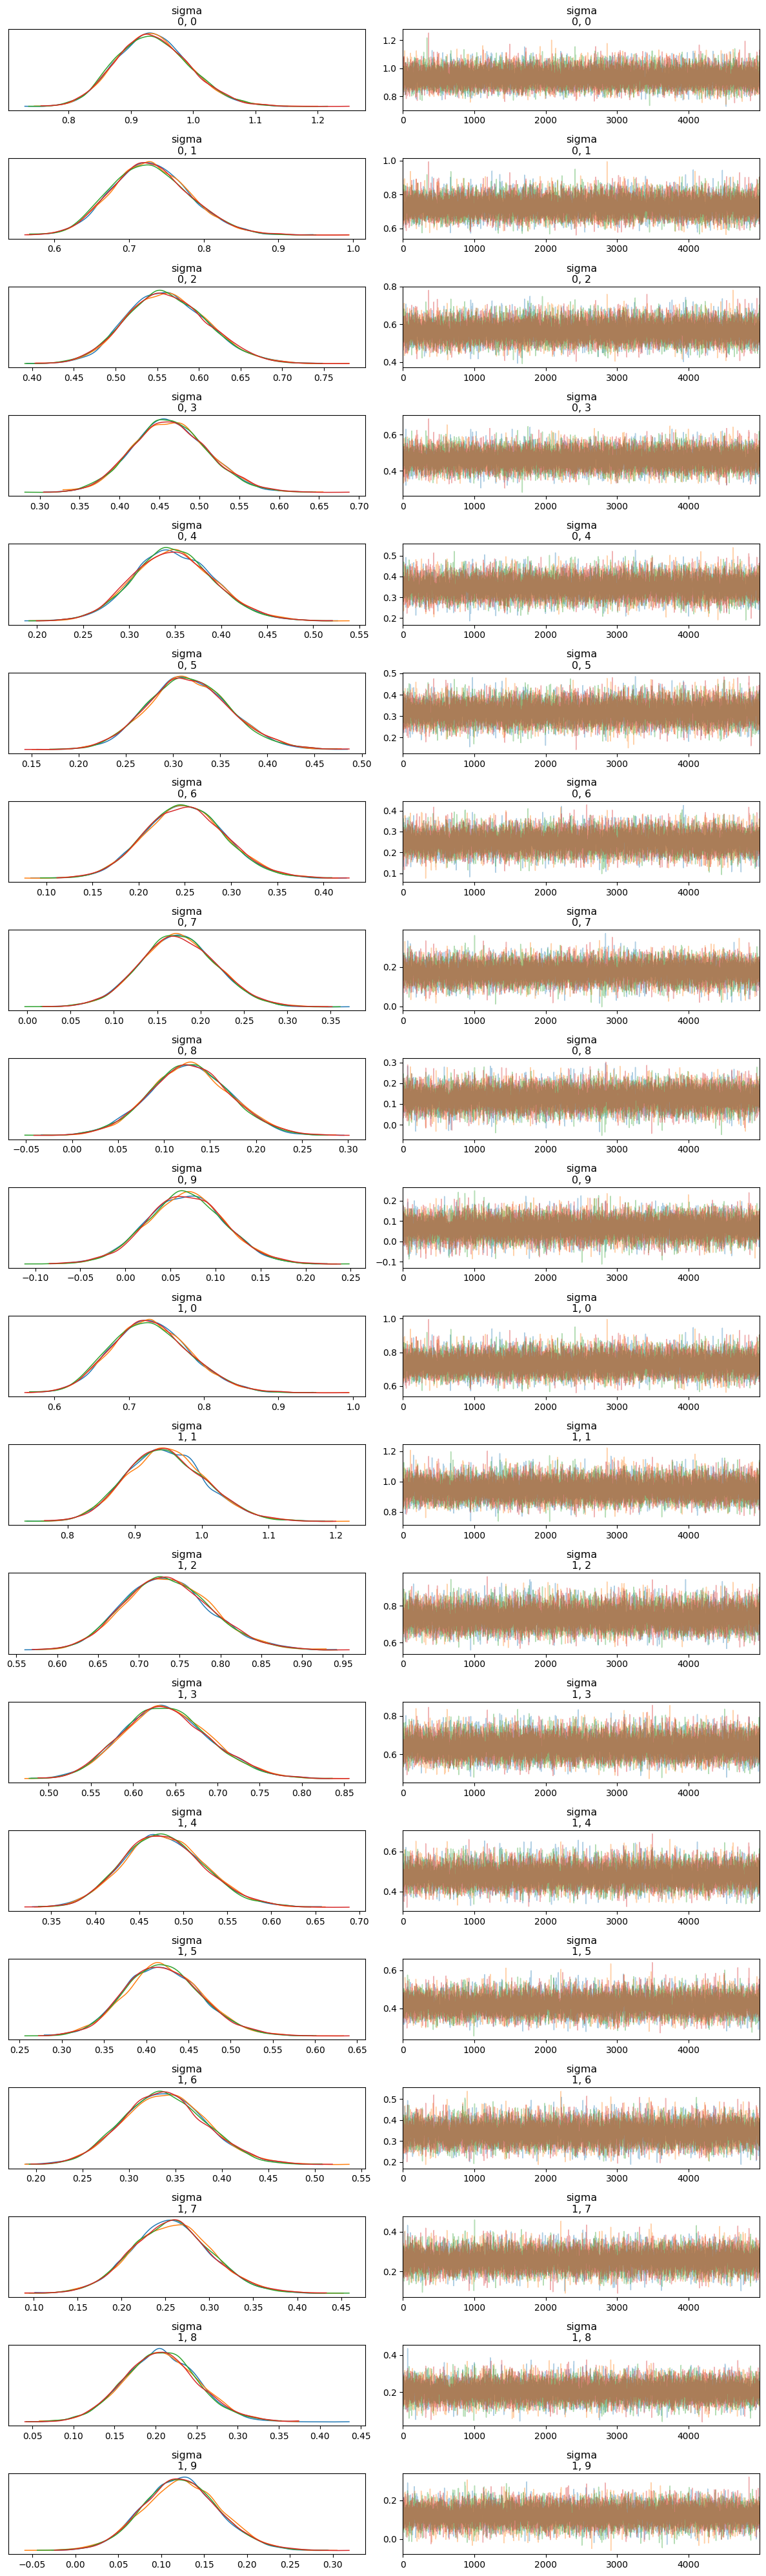

In [ ]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

In [ ]:
np.sum(cmdstanpy_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

## Going hierarchical

We consider 341 frogs from 12 genuses. For each frog we measure a function of the Body Weight (BoW) and the Brain Weight (BrW):

$$
    y_j = \log \left(\frac{BrW/BoW}{1 - BrW / BoW} \right) = \text{logit}(BrW/BoW), \quad j=1, \ldots, 341
$$

We want to study differences across the genuses


Denote with $g(j) \in \{1, \ldots, 12\}$ the genus of individual $j$.
A simple hierarchical model is

\begin{equation*}
    \begin{aligned}
        y_j \mid \theta_1, \ldots, \theta_{12}, \sigma & \sim \mathcal{N}(\theta_{g(j)}, \sigma^2) \\
        \theta_1, \ldots, \theta_{12} \mid \mu, \tau &\sim \mathcal{N}(\mu, \tau^2) \\
        \mu, \tau & \sim \mathcal{N}(\mu_0, s_0^2) \times \text{Uniform}(0, \tau_{max}) \\
        \sigma & \sim \text{Uniform}(0, \sigma_{max})
    \end{aligned}
\end{equation*}

## How to set the prior?
The ratio between bodyweight and brainweight is well studied and also has a [Wikipedia page][1]. Since we are not biologist, we use this page to elicit our prior.

[1]: https://en.wikipedia.org/wiki/Brain%E2%80%93body_mass_ratio

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def logit(x):
    return np.log(x) - np.log(1 - x)

In [ ]:
# Average brain to body ratio for frogs is 1/172
mu0 = logit(1 / 172)
mu0

-5.141663556502659

In [ ]:
from scipy.optimize import minimize

# P(a <= X <= b), with X ~ N(mu,s)
def p_in_interval(mu, s, a, b):
    dist = tfd.Normal(mu, s)
    return dist.cdf(b) - dist.cdf(a)

# Compute s0 s.t. P(a <= X <= b) >= 0.9
loss_fn = lambda x: (p_in_interval(mu0, x, logit(1.0 / 550), logit(1.0/125)) - 0.9) ** 2
s0 = minimize(loss_fn, 10).x[0]
s0

0.25077341761337146

In [ ]:
# Raughly estimate the standard deviations of the ratios to estimate taumax
ratios = 1.0 / np.array([12.0, 40.0, 40, 100, 125, 172, 550, 560, 600, 2496, 2798])
logit_ratios = logit(ratios)
taumax = 5 * np.std(logit_ratios)
taumax

8.401282171112088

In [ ]:
# No idea on sigmamax: set to 100
sigmamax = 100.0

## Let's import the data

In [ ]:
import pandas as pd

frog_data = pd.read_csv("frog_data.csv")
frog_data.head()

Order          Family    Genus Species      BoW    SVL    BrW
0  Anura  Bombinatoridae  Bombina  maxima  18543.9  60.24  45.30
1  Anura  Bombinatoridae  Bombina  maxima  11701.3  61.54  52.98
2  Anura  Bombinatoridae  Bombina  maxima  22450.8  59.80  58.70
3  Anura  Bombinatoridae  Bombina  maxima  23549.8  60.39  33.80
4  Anura  Bombinatoridae  Bombina  maxima  23091.0  60.51  40.00

In [ ]:
frog_y = logit(frog_data.BrW.values / frog_data.BoW.values)
ind2genus = np.where(
    frog_data.Genus.values[:, np.newaxis] == np.unique(frog_data.Genus))[1]

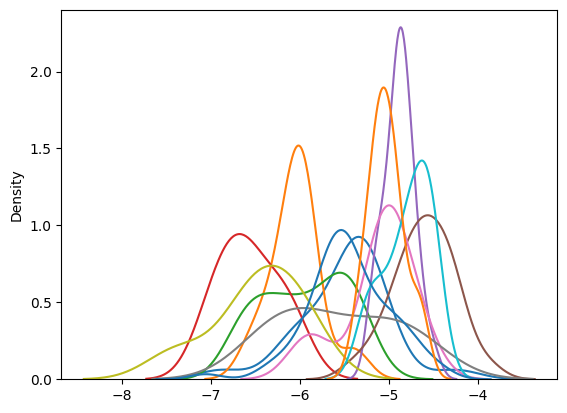

In [ ]:
fig = plt.figure()

for i, g in enumerate(np.unique(frog_data.Genus)):
    curr_y = frog_y[ind2genus == i]
    sns.kdeplot(curr_y)

plt.show()

In [ ]:
frogs_code = """
data {
    int<lower=0> J;
    int<lower=0> N;
    array[N] real y;
    array[N] int<lower=1, upper=J> g;

    real<lower=0> s0;
    real<lower=0> taumax;
    real mu0;
}

parameters {
    real mu;
    real<lower=0> tau;

    array[J] real theta;
    real<lower=0> sigma;
}


model {
    mu ~ normal(mu0, s0);
    tau ~ uniform(0, taumax);
    sigma ~ uniform(0, 100);
    theta ~ normal(mu, tau);
    for (i in 1:N) {
        y ~ normal(theta[g[i]], sigma);
    }
}
"""

# Write model to file
stan_file = "./stan/frogs_code.stan"
with open(stan_file, "w") as f:
    print(frogs_code, file=f)

# Compile stan Model
stan_model = CmdStanModel(stan_file=stan_file)

19:54:49 - cmdstanpy - INFO - compiling stan file /content/stan/frogs_code.stan to exe file /content/stan/frogs_code
INFO:cmdstanpy:compiling stan file /content/stan/frogs_code.stan to exe file /content/stan/frogs_code
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=frogs_code.stan /content/stan/frogs_code
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=frogs_code.stan --o=/content/stan/frogs_code.hpp /content/stan/frogs_code.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST

In [33]:
# Prepare input list
frogs_data = {
    "J": 12,
    "N": len(frog_y),
    "y": frog_y,
    "g": ind2genus + 1,
    "s0": s0,
    "taumax": taumax,
    "mu0": mu0
}

# Sample
stan_fit = stan_model.sample(data=frogs_data)

# Convert to arviz data type
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /content/stan/frogs_code info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseieqfx9/7mxyerd2.json
19:59:03 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code', 'id=1', 'random', 'seed=77132', 'data', 'file=/tmp/tmpseieqfx9/7mxyerd2.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code2hmlzzsz/frogs_code-20250208195903_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code', 'id=2', 'random', 'seed=77132', 'data', 'file=/tmp/tmpseieqfx9/7mxyerd2.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code2hmlzzsz/frogs_code-20250208195903_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code', 'id=3', 'random', 'seed=77132', 'data', 'file=/tmp/tmpseieqfx9/7mxyerd2.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code2hmlzzsz/frogs_code-20250208195903_3.csv', 'metho

20:02:30 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/frogs_code', 'id=1', 'random', 'seed=77132', 'data', 'file=/tmp/tmpseieqfx9/7mxyerd2.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code2hmlzzsz/frogs_code-20250208195903_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpseieqfx9/frogs_code2hmlzzsz/frogs_code-20250208195903_1.csv
 console_msgs (if any):
	/tmp/tmpseieqfx9/frogs_code2hmlzzsz/frogs_code-20250208195903_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75

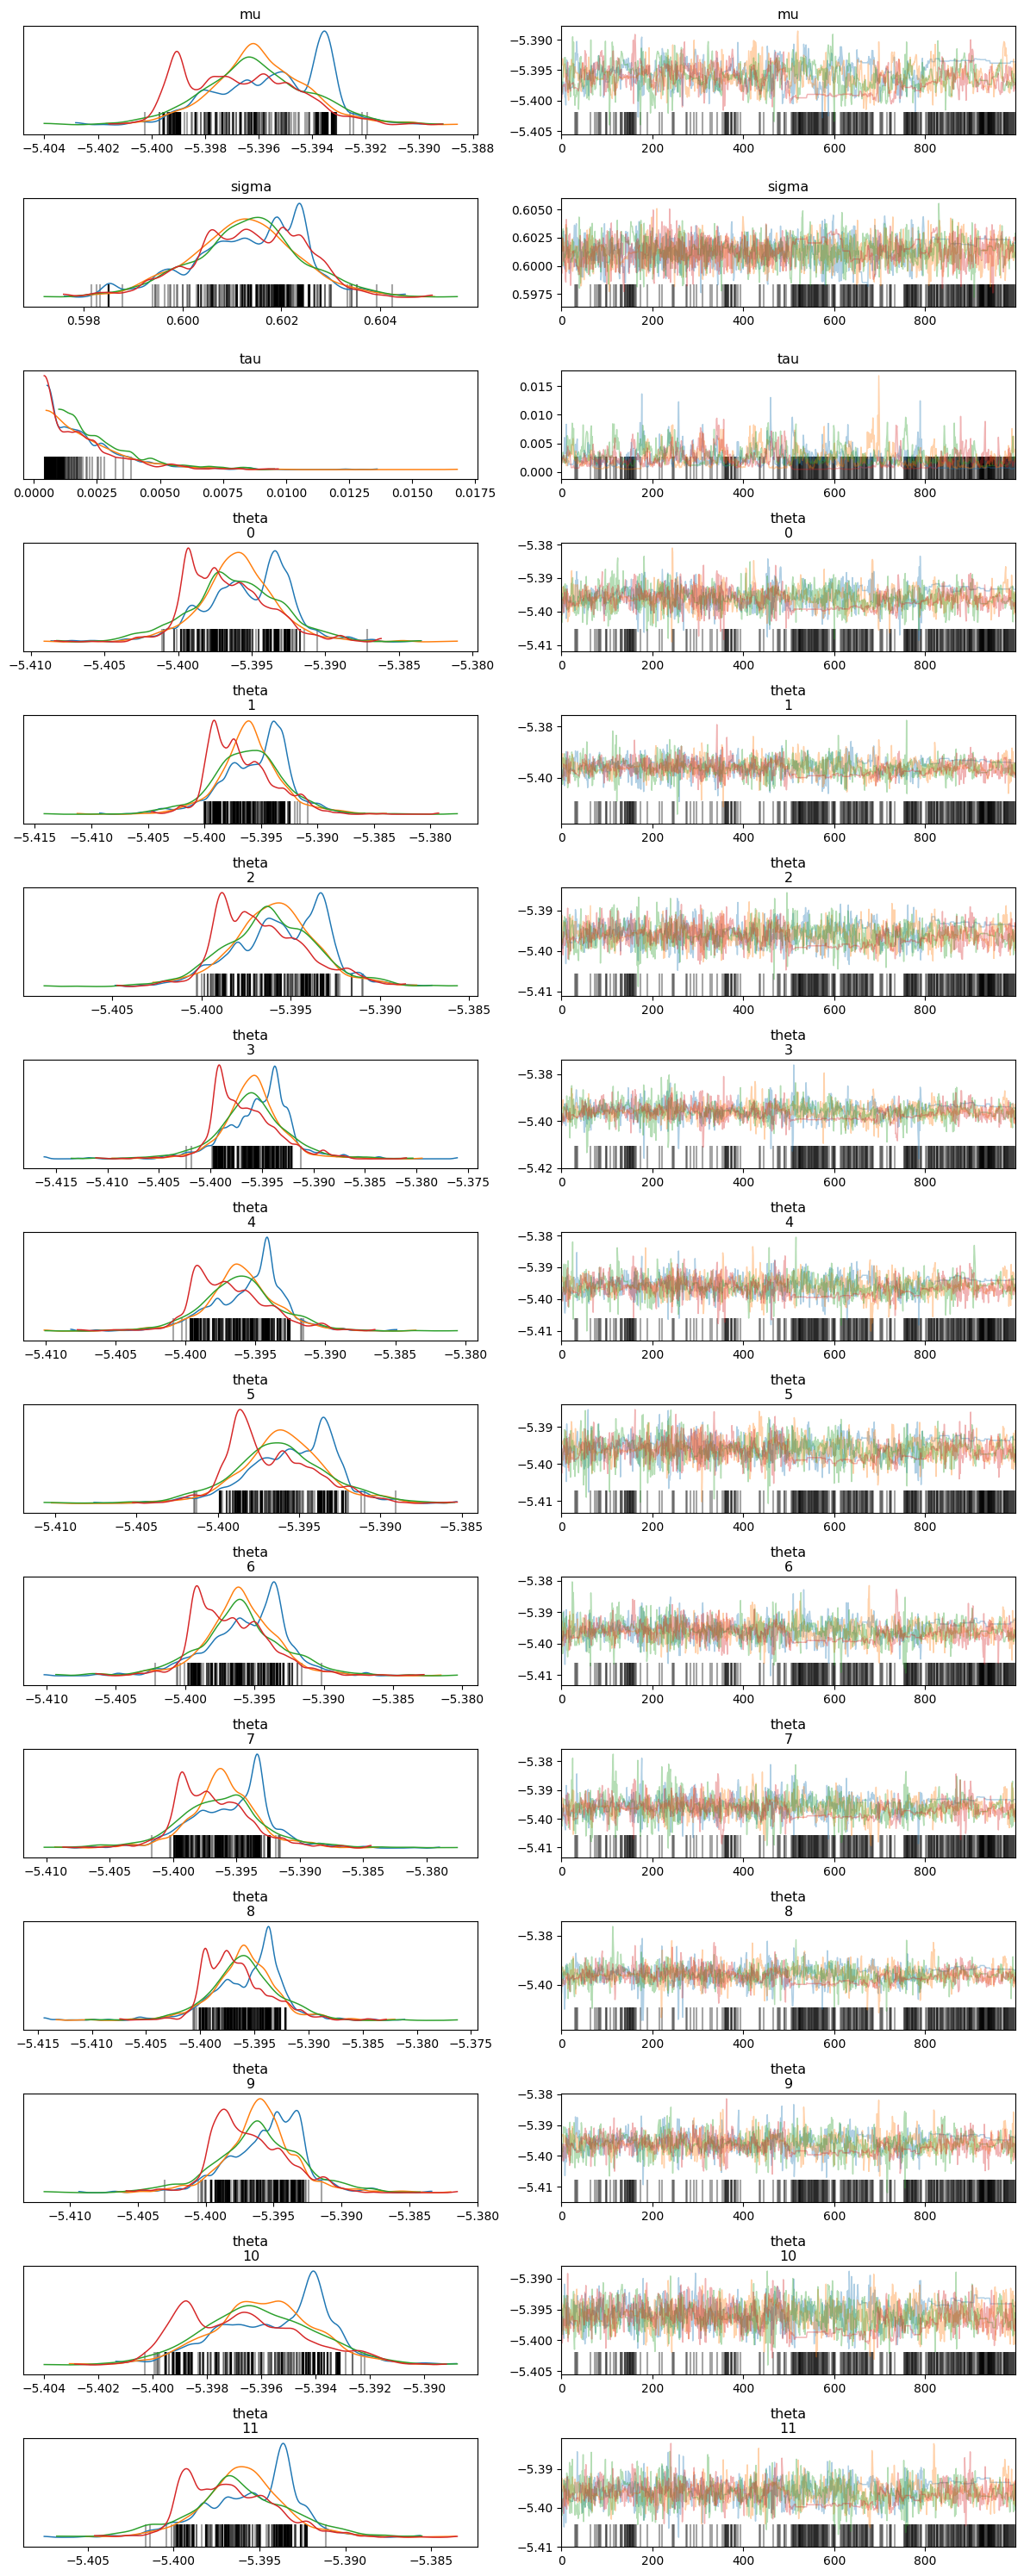

In [34]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()

In [35]:
np.sum(cmdstanpy_data.sample_stats.diverging)

## We have 271 diverging iterations!

<xarray.DataArray 'diverging' ()> Size: 8B
array(435)

In [36]:
def split_diverging(data, var_name):
    div_iters = np.where(data.sample_stats.diverging)
    non_div_iters = np.where(data.sample_stats.diverging == False)
    vals = data.posterior[var_name].values
    return (vals[div_iters], vals[non_div_iters])

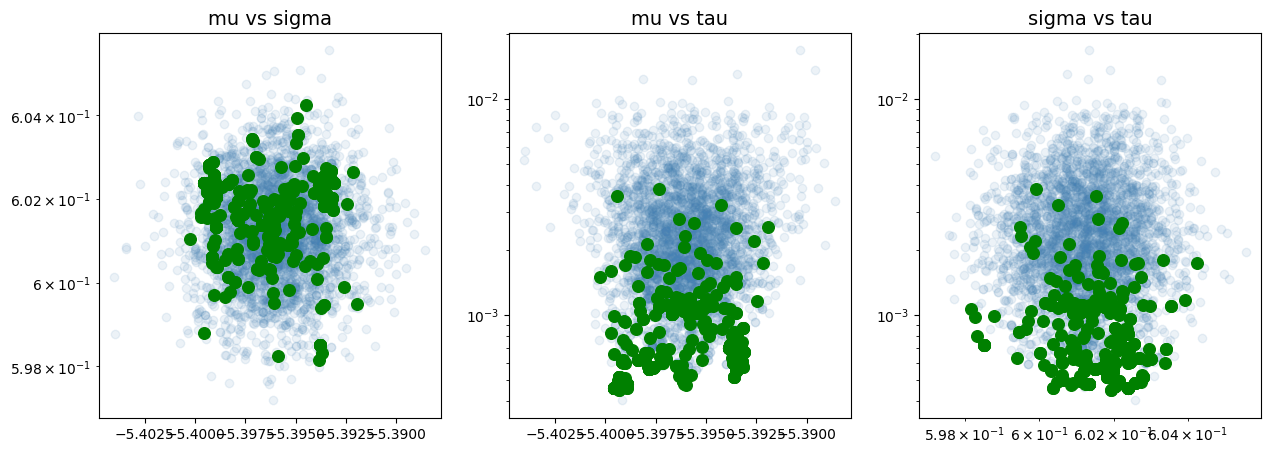

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

var_names = ["mu", "sigma", "tau"]
cols = np.array(["steelblue", "forestgreen"])

idx = 0
for i, v1 in enumerate(var_names):
    div1, nondiv1 = split_diverging(cmdstanpy_data, v1)
    for v2 in var_names[i+1:]:
        div2, nondiv2 = split_diverging(cmdstanpy_data, v2)
        axes[idx].scatter(nondiv1, nondiv2, color="steelblue", alpha=0.1)
        axes[idx].scatter(div1, div2, s=70, color="green")
        axes[idx].set_title("{0} vs {1}".format(v1, v2), fontsize=14)

        if v1 in ["sigma", "tau"]:
            axes[idx].set_xscale("log")

        if v2 in ["sigma", "tau"]:
            axes[idx].set_yscale("log")

        idx += 1

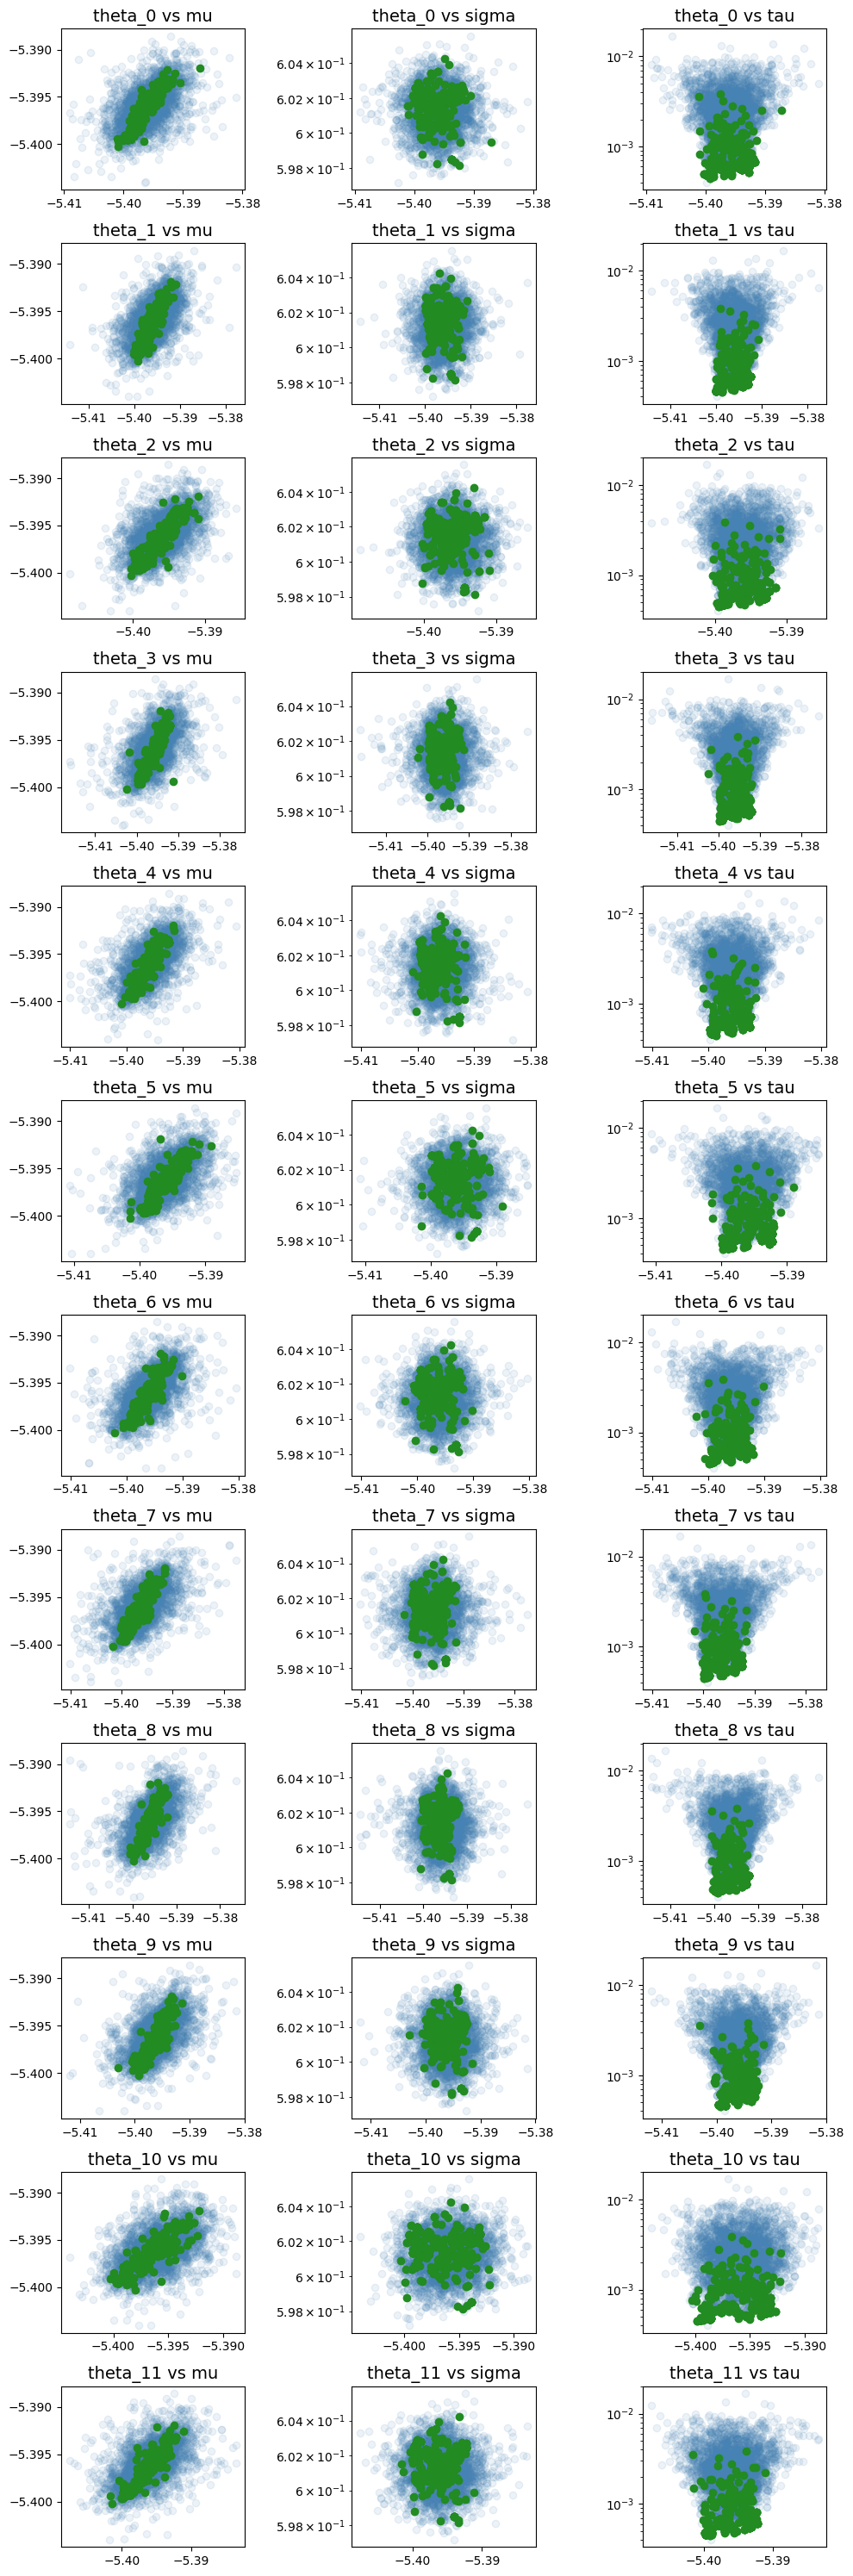

In [38]:
fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(10, 30))

var_names = ["mu", "sigma", "tau"]
cols = np.array(["steelblue", "forestgreen"])

divtheta, nondivtheta = split_diverging(cmdstanpy_data, "theta")

for i, v1 in enumerate(var_names):
    div1, nondiv1 = split_diverging(cmdstanpy_data, v1)
    for j in range(12):
        axes[j][i].scatter(nondivtheta[:, j], nondiv1, color="steelblue", alpha=0.1)
        axes[j][i].scatter(divtheta[:, j], div1, color="forestgreen")
        axes[j][i].set_title("theta_{1} vs {0}".format(v1, j), fontsize=14)
        if v1 in ["sigma", "tau"]:
            axes[j][i].set_yscale("log")


plt.tight_layout()
plt.show()

In [39]:
frogs_code_reparam = """
data {
    int<lower=0> J;
    int<lower=0> N;
    array[N] real y;
    array[N] int<lower=1, upper=J> g;

    real<lower=0> s0;
    real<lower=0> taumax;
    real mu0;
}

parameters {
    real mu;
    real<lower=0> tau;

    vector[J] theta_raw;
    real<lower=0> sigma;
}

transformed parameters {
    vector[J] theta;

    theta = mu + theta_raw * tau;
}


model {
    mu ~ normal(mu0, s0);
    tau ~ uniform(0, taumax);
    sigma ~ uniform(0, 100);
    theta_raw ~ normal(0, 1);
    for (i in 1:N) {
        y ~ normal(theta[g[i]], sigma);
    }
}
"""

stan_file = "./stan/frogs_code_reparam.stan"
with open(stan_file, "w") as f:
    print(frogs_code_reparam, file=f)
stan_model = CmdStanModel(stan_file=stan_file)

20:04:55 - cmdstanpy - INFO - compiling stan file /content/stan/frogs_code_reparam.stan to exe file /content/stan/frogs_code_reparam
INFO:cmdstanpy:compiling stan file /content/stan/frogs_code_reparam.stan to exe file /content/stan/frogs_code_reparam
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=frogs_code_reparam.stan /content/stan/frogs_code_reparam
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=frogs_code_reparam.stan --o=/content/stan/frogs_code_reparam.hpp /content/stan/frogs_code_reparam.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/

In [40]:
stan_fit = stan_model.sample(data=frogs_data)
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

DEBUG:cmdstanpy:cmd: /content/stan/frogs_code_reparam info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseieqfx9/79kubhsf.json
20:12:00 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code_reparam', 'id=1', 'random', 'seed=85490', 'data', 'file=/tmp/tmpseieqfx9/79kubhsf.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code_reparamokck3n9g/frogs_code_reparam-20250208201200_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code_reparam', 'id=2', 'random', 'seed=85490', 'data', 'file=/tmp/tmpseieqfx9/79kubhsf.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code_reparamokck3n9g/frogs_code_reparam-20250208201200_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code_reparam', 'id=3', 'random', 'seed=85490', 'data', 'file=/tmp/tmpseieqfx9/79kubhsf.json', 'output', 'file=/tmp/tmpseieqfx9/fro

20:14:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/frogs_code_reparam', 'id=1', 'random', 'seed=85490', 'data', 'file=/tmp/tmpseieqfx9/79kubhsf.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code_reparamokck3n9g/frogs_code_reparam-20250208201200_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpseieqfx9/frogs_code_reparamokck3n9g/frogs_code_reparam-20250208201200_1.csv
 console_msgs (if any):
	/tmp/tmpseieqfx9/frogs_code_reparamokck3n9g/frogs_code_reparam-20250208201200_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


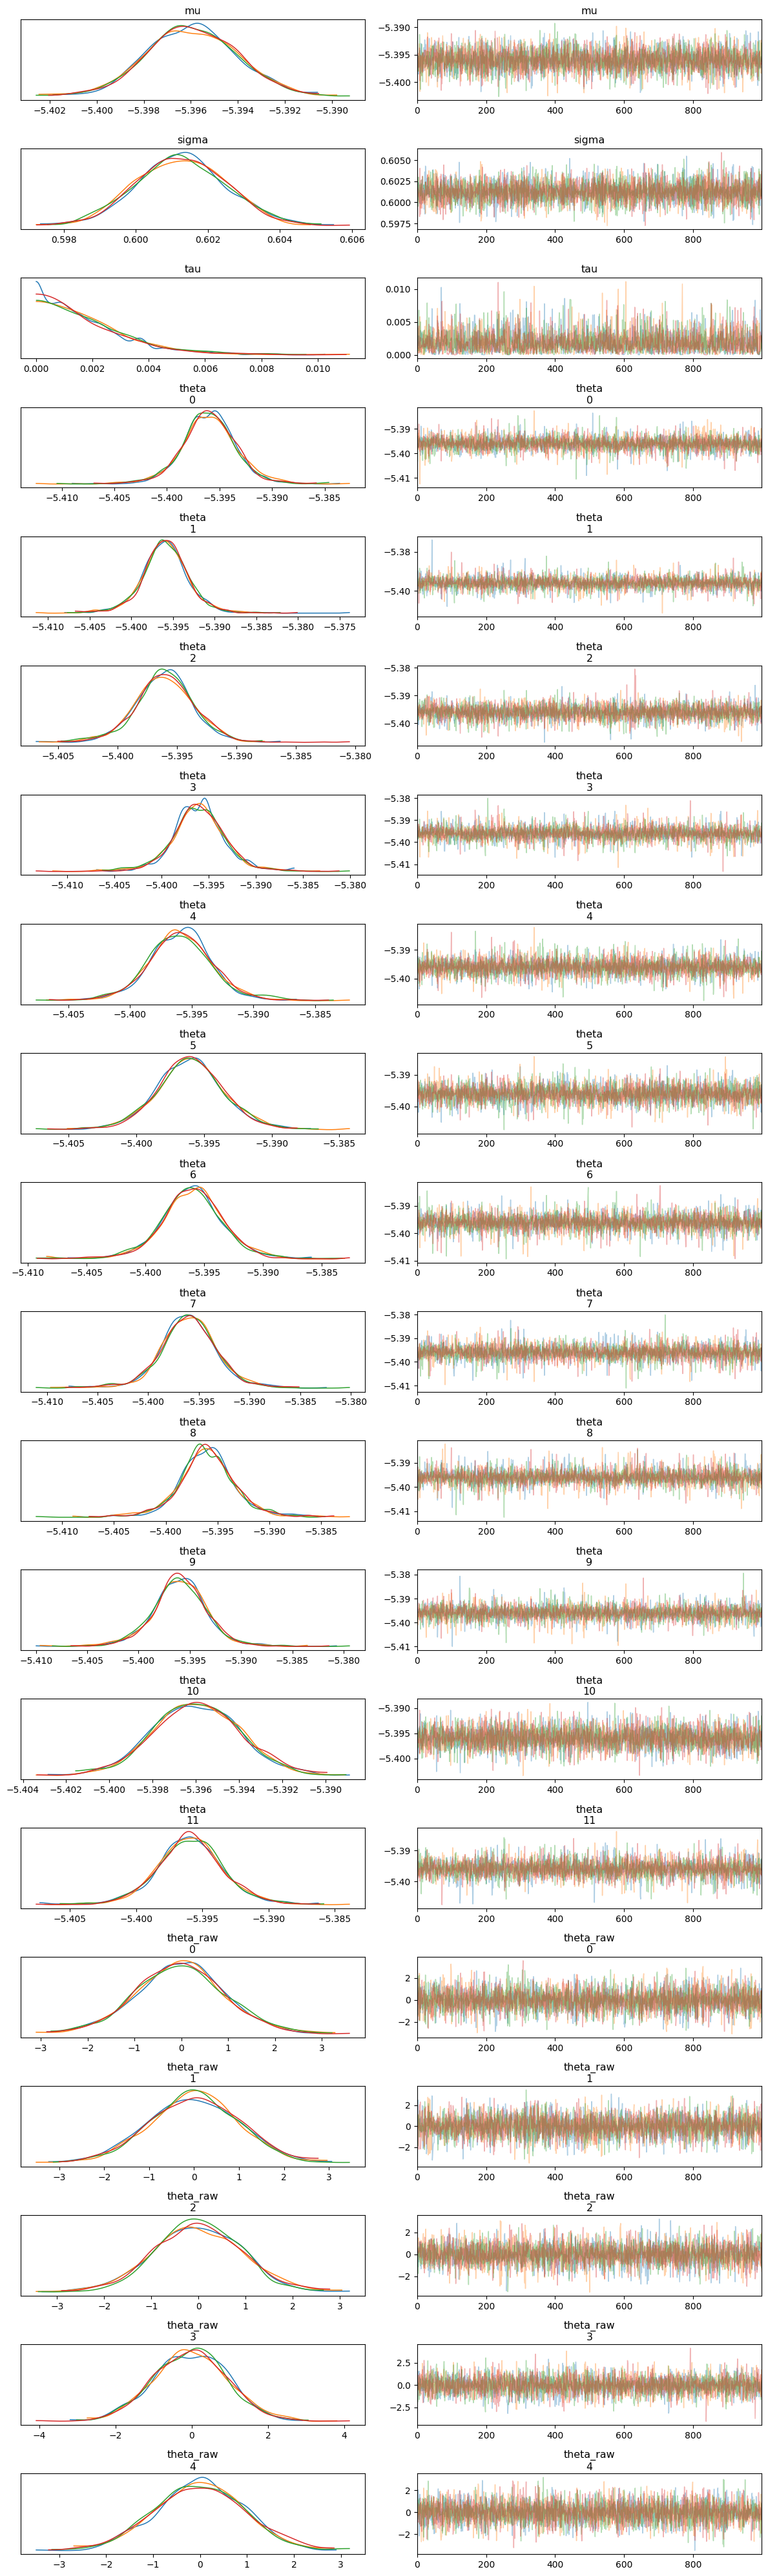

In [41]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

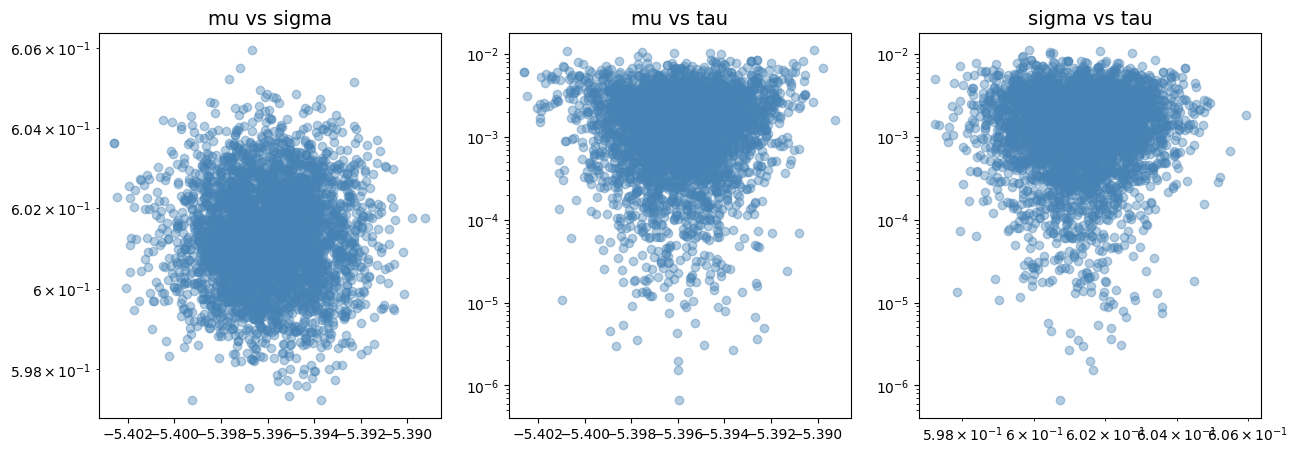

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

var_names = ["mu", "sigma", "tau"]
cols = np.array(["steelblue", "forestgreen"])

idx = 0
for i, v1 in enumerate(var_names):
    div1, nondiv1 = split_diverging(cmdstanpy_data, v1)
    for v2 in var_names[i+1:]:
        div2, nondiv2 = split_diverging(cmdstanpy_data, v2)
        axes[idx].scatter(nondiv1, nondiv2, color="steelblue", alpha=0.4)
        axes[idx].scatter(div1, div2, color="forestgreen")
        axes[idx].set_title("{0} vs {1}".format(v1, v2), fontsize=14)

        if v1 in ["sigma", "tau"]:
            axes[idx].set_xscale("log")

        if v2 in ["sigma", "tau"]:
            axes[idx].set_yscale("log")

        idx += 1

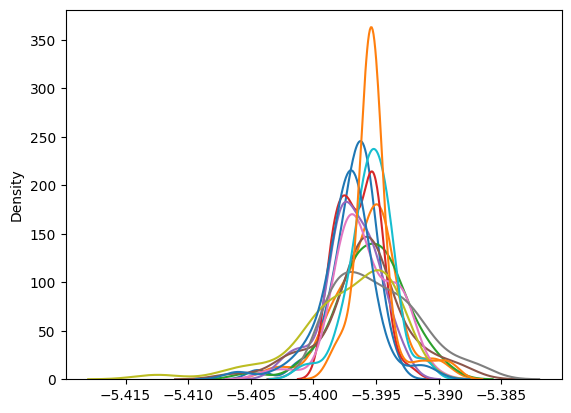

In [43]:
fig = plt.figure()

for i in range(12):
    sns.kdeplot(cmdstanpy_data.posterior.theta[:, i, :].values.reshape(-1, ))

plt.show()

# Other startegies to fix diverging iterations


Increase `adapt_delta` (target acceptance rate) from the default value (0.8) to (0.9, 0.95, 0.99, 0.999)

Decrease the initial `step_size` from 1 (default value)

Increse `max_treedepth` (something very specific of NUTS) from 10

In [44]:
stan_fit = stan_model.sample(data=frogs_data, adapt_delta=0.99,
                             step_size=0.5, max_treedepth=15)
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

DEBUG:cmdstanpy:cmd: /content/stan/frogs_code_reparam info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseieqfx9/i_kkg8m1.json
20:15:05 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code_reparam', 'id=1', 'random', 'seed=33304', 'data', 'file=/tmp/tmpseieqfx9/i_kkg8m1.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code_reparamvt_d5hee/frogs_code_reparam-20250208201505_1.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'stepsize=0.5', 'adapt', 'engaged=1', 'delta=0.99']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code_reparam', 'id=2', 'random', 'seed=33304', 'data', 'file=/tmp/tmpseieqfx9/i_kkg8m1.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code_reparamvt_d5hee/frogs_code_reparam-20250208201505_2.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'stepsize=0.5', 'adapt', 'engaged=1', 'delta=0.99']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/frogs_code_rep

21:01:05 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/frogs_code_reparam', 'id=1', 'random', 'seed=33304', 'data', 'file=/tmp/tmpseieqfx9/i_kkg8m1.json', 'output', 'file=/tmp/tmpseieqfx9/frogs_code_reparamvt_d5hee/frogs_code_reparam-20250208201505_1.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'stepsize=0.5', 'adapt', 'engaged=1', 'delta=0.99']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpseieqfx9/frogs_code_reparamvt_d5hee/frogs_code_reparam-20250208201505_1.csv
 console_msgs (if any):
	/tmp/tmpseieqfx9/frogs_code_reparamvt_d5hee/frogs_code_reparam-20250208201505_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

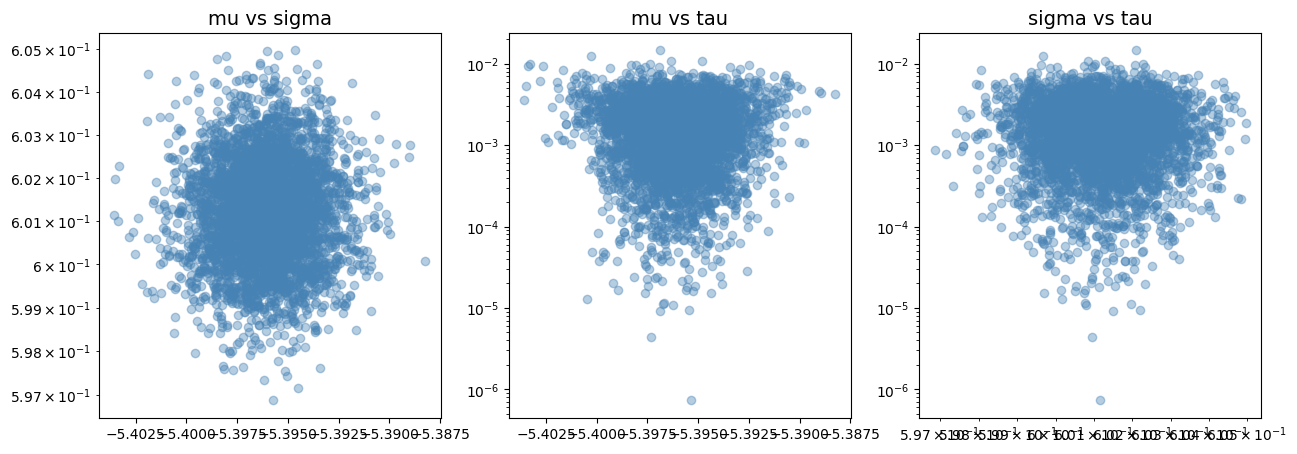

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

var_names = ["mu", "sigma", "tau"]
cols = np.array(["steelblue", "forestgreen"])

idx = 0
for i, v1 in enumerate(var_names):
    div1, nondiv1 = split_diverging(cmdstanpy_data, v1)
    for v2 in var_names[i+1:]:
        div2, nondiv2 = split_diverging(cmdstanpy_data, v2)
        axes[idx].scatter(nondiv1, nondiv2, color="steelblue", alpha=0.4)
        axes[idx].scatter(div1, div2, color="forestgreen")
        axes[idx].set_title("{0} vs {1}".format(v1, v2), fontsize=14)

        if v1 in ["sigma", "tau"]:
            axes[idx].set_xscale("log")

        if v2 in ["sigma", "tau"]:
            axes[idx].set_yscale("log")

        idx += 1